# Squeezing in atomic qudits

In this notebook we will look into experiments with atomic qudits and reproduce them with quantum circuits. We first want to look at what we are trying to reproduce with pennylane. The graph below is from a [paper](https://arxiv.org/abs/1507.03782) by Helmut Strobel. In this paper the collective spin of a Bose-Einstein-Condensate is used to observe nonlinearity in spin squeezing.

In [25]:
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

In [26]:
# we employ in the data from the paper by Strobel et al.
strobel_15_dB = np.array([  0.51993068,  10.39861352,  20.5372617 ,  30.41594454,
        40.81455806,  45.49393414,  50.6932409 ,  56.152513  ,
        60.05199307,  69.93067591,  79.80935875,  90.98786828,
       100.08665511, 109.96533795, 120.36395147, 130.24263432,
       139.86135182, 150.51993068, 160.13864818, 170.01733102,
       180.1559792 ])

strobel_15_alpha = np.array([  9.27455357,  8.03571429,  6.19419643,  3.54910714, -0.46875   ,
       -2.27678571, -4.11830357, -4.01785714, -2.94642857,  1.30580357,
        4.55357143,  6.99776786,  8.50446429,  9.140625  , 10.41294643,
       10.546875  , 10.64732143, 10.27901786,  9.74330357,  9.40848214,
        8.27008929])

# and the values for 25ms
strobel_25_dB = np.array([  0.51993068,  10.39861352,  20.5372617 ,  30.41594454,
        40.81455806,  45.49393414,  50.6932409 ,  56.152513  ,
        60.05199307,  69.93067591,  79.80935875,  90.98786828,
       100.08665511, 109.96533795, 120.36395147, 130.24263432,
       139.86135182, 150.51993068, 160.13864818, 170.01733102,
       180.1559792 ])

strobel_25_alpha = np.array([16.07142857, 15.46875   , 14.02901786, 11.71875   ,  8.40401786,
        4.72098214,  2.20982143, -0.46875   ,  0.        ,  2.74553571,
        7.734375  , 10.98214286, 13.39285714, 14.89955357, 15.73660714,
       16.50669643, 17.00892857, 17.31026786, 17.24330357, 16.77455357,
       15.80357143])

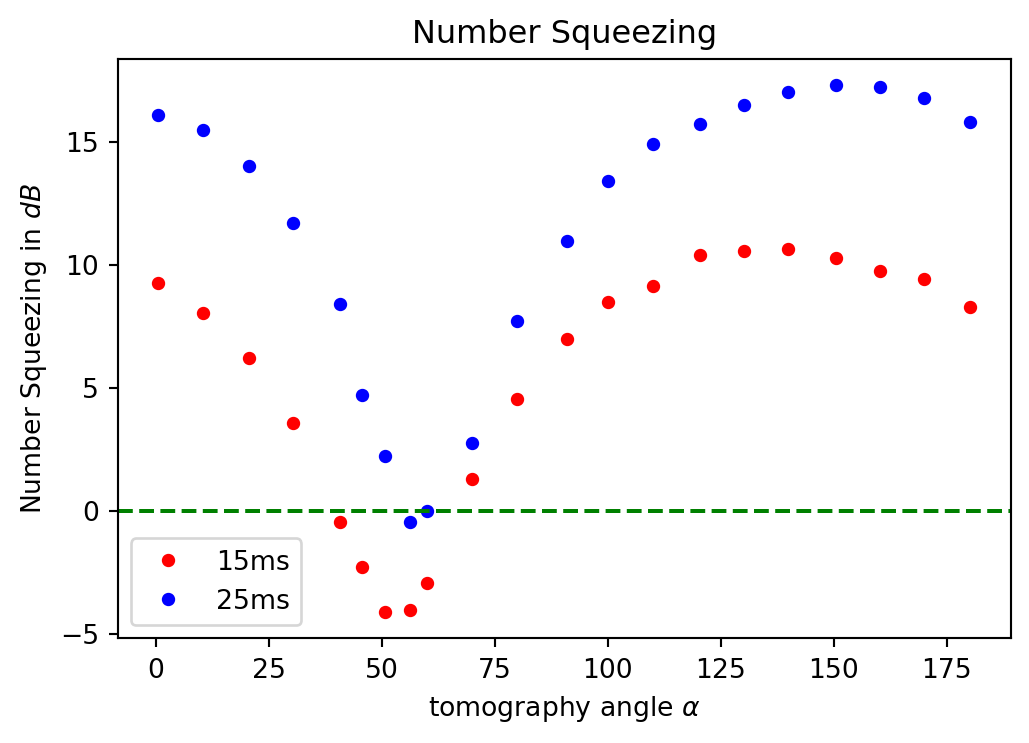

In [27]:
plt.figure(dpi=96)
plt.title("Number Squeezing")
plt.plot(strobel_15_dB, strobel_15_alpha, 'ro', label="15ms", markersize=4)
plt.plot(strobel_25_dB, strobel_25_alpha, 'bo', label="25ms", markersize=4)
plt.axhline(y=0, color='g', linestyle='--')
plt.ylabel(r'Number Squeezing in $dB$')
plt.xlabel(r'tomography angle $\alpha$')
_ = plt.legend()

This number squeezing is achieved by performing the following Bloch-sphere rotations. 

We prepare the collective spin such that the Bloch-sphere-vector points to one of the poles. 


1. __First step__.  As a first step the vector is rotated onto the equator.

2. __Second step__ . Then the state is being squeezed, such that it starts to wrap around the Bloch-sphere.

3. __Third step__ . In the last step we rotate the state around the $X$-axis. This rotation corresponds to the angle $\alpha$ in this notebook.


We will now simulate the sequence in qiskit.

In [4]:
from qiskit_cold_atom.providers import ColdAtomProvider

provider = ColdAtomProvider()
backend = provider.get_backend("collective_spin_simulator")


$$ H_{\text{OAT}}(\chi, \Delta, \Omega) =  \chi L_{z}^2 + \Delta L_{z} + \Omega L_{x}$$

from the paper we know the values to be:

In [5]:
Nat = 200;
l = Nat/2
omegax = 2*np.pi*20;
t1 = 15e-3;
t2 = 25e-3;
Lambda = 1.5;#1.5

chi = Lambda*abs(omegax)/Nat;
alpha = 0;

so how does the circuit typically look ?

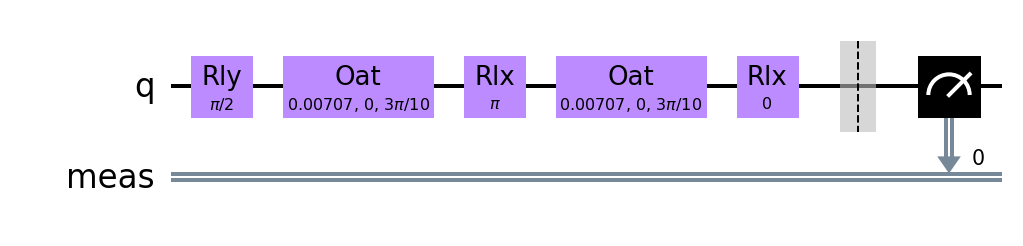

In [6]:
from qiskit import QuantumCircuit
from qiskit_cold_atom.spins.spins_gate_library import OATGate
from qiskit.visualization import plot_histogram

qc = QuantumCircuit(1)

qc.ly(np.pi/2, 0)
qc.append(OATGate(chi=chi*t1/2, delta=0, omega=omegax*t1/2), qargs=[0])
qc.lx(np.pi, 0)
qc.append(OATGate(chi=chi*t1/2, delta=0, omega=omegax*t1/2), qargs=[0])
qc.lx(alpha, 0)
qc.measure_all()

qc.draw('mpl')

In [7]:
def mean_var_from_counts(counts):
    '''calculate mean and variance from the counts.
    
    Args:
        counts: a dict whose keys are the observed integers for the spin
                and whose values is the number of observations
                
    Returns:
        mean, var: mean and variance of the observed counts
    '''
    
    mean = 0;
    var = 0;
    
    count_sum = 0;
    for k,v in counts.items():
        mean += int(k)*v
        count_sum += v
        
    mean = mean/count_sum
    for k,v in counts.items():
        var += (int(k)-mean)**2*v/count_sum
    return mean, var

and now calculate the variance as presented above.

In [8]:
alphas = np.linspace(0, np.pi, 15)
variances_1 = np.zeros(len(alphas))
variances_2 = np.zeros(len(alphas))

for i in range(len(alphas)):
    if i%10==0:
        print("step", i)
    
    # first time step
    qc = QuantumCircuit(1)
    qc.lx(np.pi/2, 0)
    qc.lz(np.pi/2, 0)
    qc.append(OATGate(chi=chi*t1/2, delta=0, omega=omegax*t1/2), qargs=[0])
    qc.lx(np.pi, 0)
    qc.append(OATGate(chi=chi*t1/2, delta=0, omega=omegax*t1/2), qargs=[0])

    qc.lx(-alphas[i], 0)
    qc.measure_all()
    job = backend.run(qc, shots = 1000, spin=Nat/2, seed=14)
    counts = job.result().get_counts()
    mean, var = mean_var_from_counts(counts)
    variances_1[i] = var;
    
    # second time step
    qc = QuantumCircuit(1)
    qc.lx(np.pi/2, 0)
    qc.lz(np.pi/2, 0)
    qc.append(OATGate(chi=chi*t2/2, delta=0, omega=omegax*t2/2), qargs=[0])
    qc.lx(np.pi, 0)
    qc.append(OATGate(chi=chi*t2/2, delta=0, omega=omegax*t2/2), qargs=[0])

    qc.lx(-alphas[i], 0)
    qc.measure_all()
    job = backend.run(qc, shots = 1000, spin=Nat/2, seed=14)
    counts = job.result().get_counts()
    mean, var = mean_var_from_counts(counts)
    
    variances_2[i] = var;

step 0
step 10


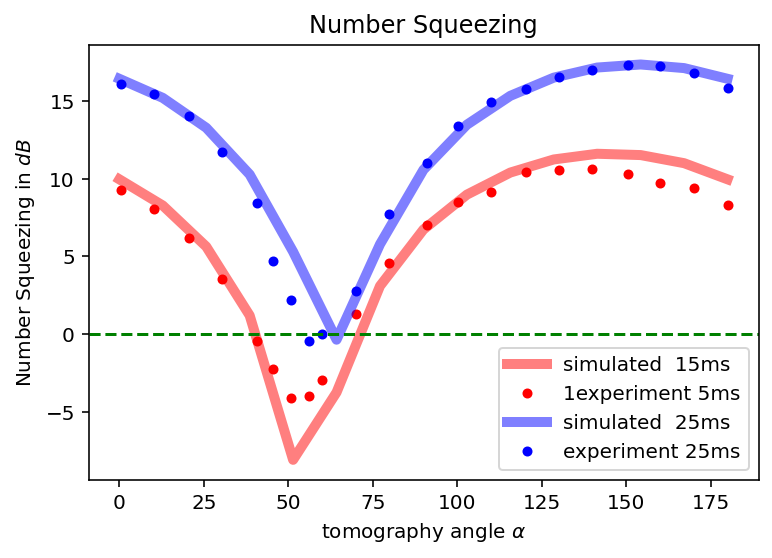

In [11]:
def number_squeezing_factor_to_db(var_CSS, var):
    return 10*np.log10(var/var_CSS)

f, ax = plt.subplots()
ax.set_title("Number Squeezing")

ax.plot(np.rad2deg(alphas), number_squeezing_factor_to_db(l/2, variances_1),'r-', lw = 5, label="simulated  15ms", alpha = 0.5)
ax.plot(strobel_15_dB, strobel_15_alpha, 'ro', label="1experiment 5ms", markersize=4)
ax.plot(np.rad2deg(alphas), number_squeezing_factor_to_db(l/2, variances_2),'b-', lw = 5, label="simulated  25ms", alpha = 0.5)
ax.plot(strobel_25_dB, strobel_25_alpha, 'bo', label="experiment 25ms", markersize=4)
ax.axhline(y=0, color='g', linestyle='--')
ax.set_ylabel(r'Number Squeezing in $dB$')
ax.set_xlabel(r'tomography angle $\alpha$')
ax.legend()

# Optional: Working on a cloud simulator

We would also like to send such circuits to some real hardware and investigate these results. In this last section, we will present this possibility with the [synqs](htttps://qsimsim.synqs.org) provider. 


<div class="alert alert-block alert-info">
<b>Note:</b> To run the cells in this part of the tutorial that interface with a remote device backend, you'll need to have a registered account with a valid username and token for this provider.</div>

In a first step, it is necessary to import the cold atom provider.

In [2]:
from qiskit_cold_atom.providers import ColdAtomProvider
from qiskit.circuit import QuantumCircuit, Parameter

from pprint import pprint

In [3]:
provider = ColdAtomProvider.load_account()

spin_device_backend = provider.get_backend("synqs_single_qudit_simulator")
pprint(spin_device_backend.configuration().supported_instructions)

['rLx', 'rLz', 'rLz2', 'measure', 'barrier', 'load']


In [4]:
alpha = Parameter("alpha")

Nat = 200
l = Nat / 2  # spin length
omegax = 2 * np.pi * 20
t1 = 15e-3
t2 = 25e-3
Lambda = 1.5

chi = Lambda * abs(omegax) / Nat

Ntrott = 15;
alphas = np.linspace(0, np.pi, 15)

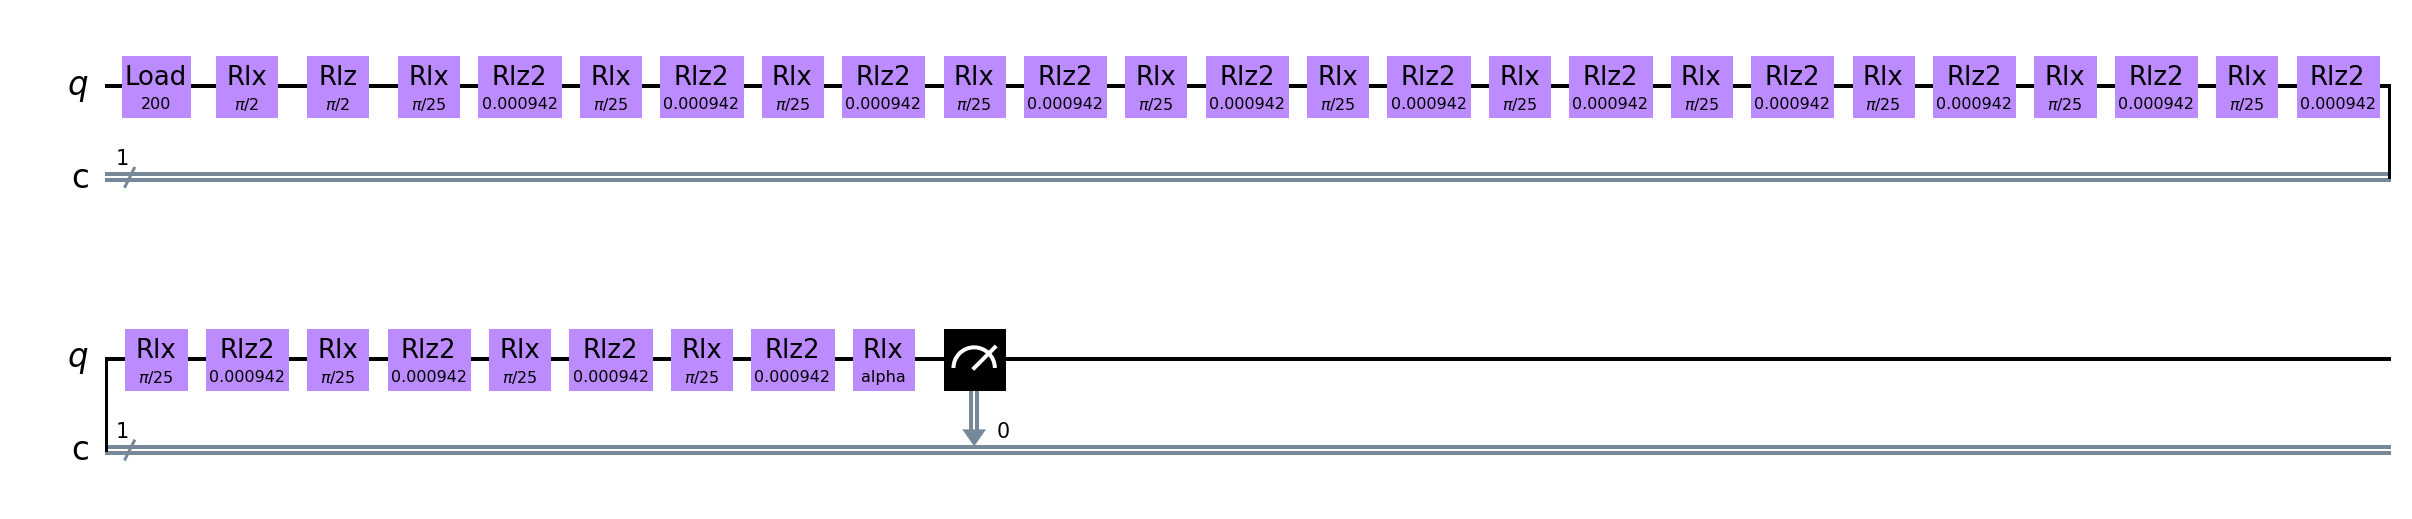

In [7]:
circuit1 = QuantumCircuit(1, 1)
circuit1.load_spins(0,Nat)
circuit1.lx(np.pi/2, 0)
circuit1.lz(np.pi / 2, 0)
for ii in range(Ntrott):
    circuit1.lx(omegax*t1/Ntrott, 0)
    circuit1.lz2(chi*t1/Ntrott, 0)
circuit1.lx(alpha, 0)
circuit1.measure(0, 0)
circuit1.draw(output='mpl')

In [8]:
circuit1_list = [circuit1.bind_parameters({alpha: -a%(2*np.pi)}) for a in alphas]

In [9]:
job1 = spin_device_backend.run(circuit1_list, shots = 500)

In [10]:
job1.job_id()

'20211123_093216-singlequdit-synqs_test-20859'

### Next job:

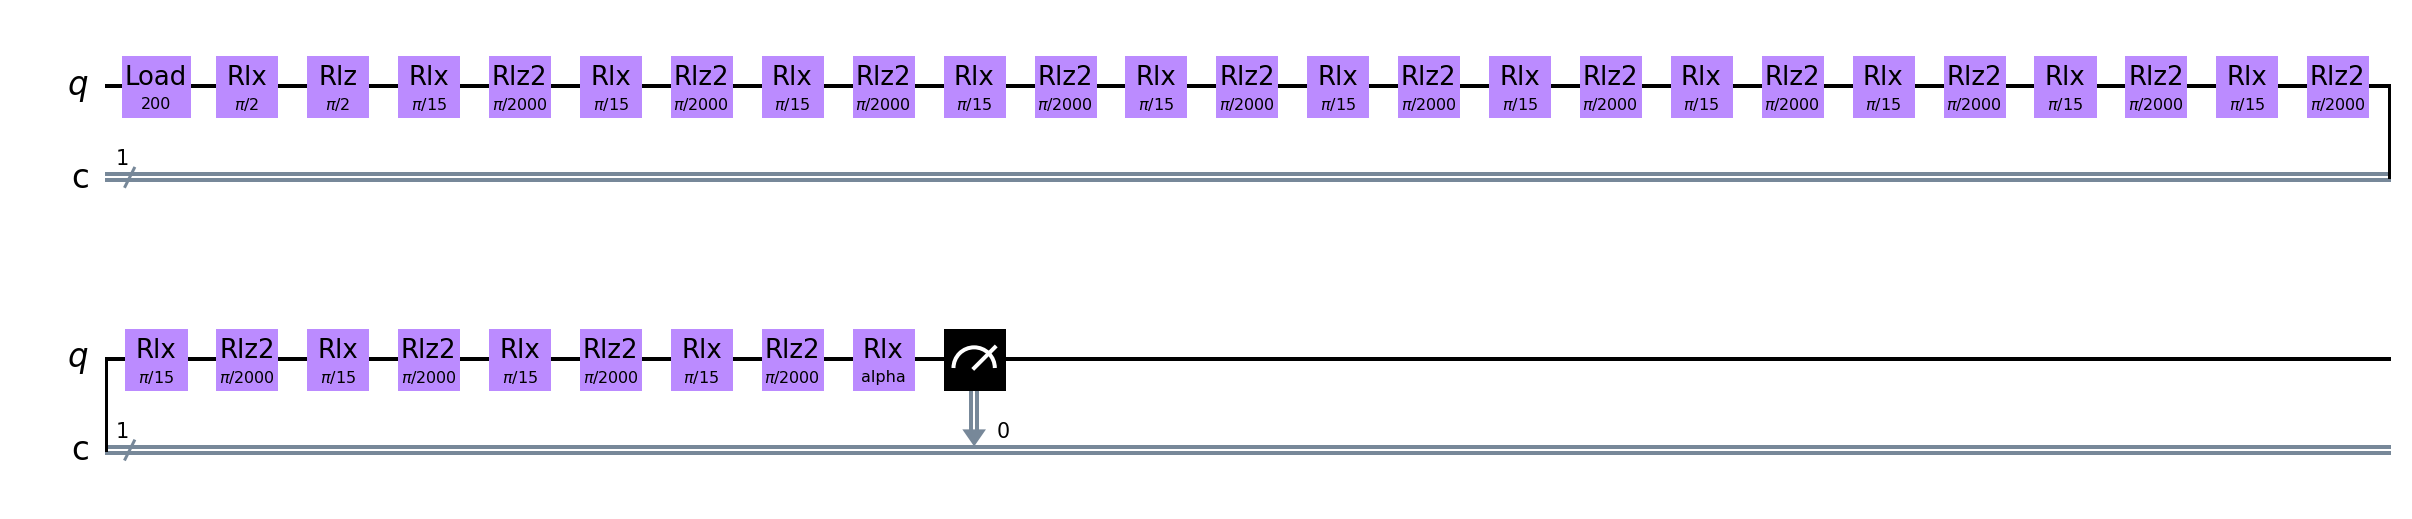

In [11]:
circuit1 = QuantumCircuit(1, 1)
circuit1.load_spins(0,Nat)
circuit1.lx(np.pi/2, 0)
circuit1.lz(np.pi / 2, 0)
for ii in range(Ntrott):
    circuit1.lx(omegax*t2/Ntrott, 0)
    circuit1.lz2(chi*t2/Ntrott, 0)
circuit1.lx(alpha, 0)
circuit1.measure(0, 0)
circuit1.draw(output='mpl')

In [13]:
circuit2_list = [circuit1.bind_parameters({alpha: -a%(2*np.pi)}) for a in alphas]

In [14]:
job2 = spin_device_backend.run(circuit2_list, shots = 500)

In [15]:
job2.job_id()

'20211123_093303-singlequdit-synqs_test-5b427'

### Retrieving jobs:

A job that has been run in a previous session can also be retrieved from the backend by providing the `job_id`:

In [16]:
job_retrieved1 = spin_device_backend.retrieve_job(job_id = job1.job_id())

print("job status: ", job_retrieved1.status())

job status:  JobStatus.DONE


In [19]:
job_retrieved2 = spin_device_backend.retrieve_job(job_id = job2.job_id())

print("job status: ", job_retrieved2.status())

job status:  JobStatus.DONE


The result of the job can be accessed by directly calling `job.result()` which returns a `Qiskit.Result` object:

In [18]:
result1 = job_retrieved1.result()
#print(type(result1))

In [20]:
result2 = job_retrieved2.result()
#print(type(result2))

In [21]:
outcomes1 = [result1.get_memory(i) for i in range(len(circuit1_list))]
outcomes2 = [result2.get_memory(i) for i in range(len(circuit2_list))]

In [22]:
variances_1 = [np.var(np.array(counts1, dtype=float)) for counts1 in outcomes1]
variances_2 = [np.var(np.array(counts2, dtype=float)) for counts2 in outcomes2]

variances_1 = np.array(variances_1)
variances_2 = np.array(variances_2)

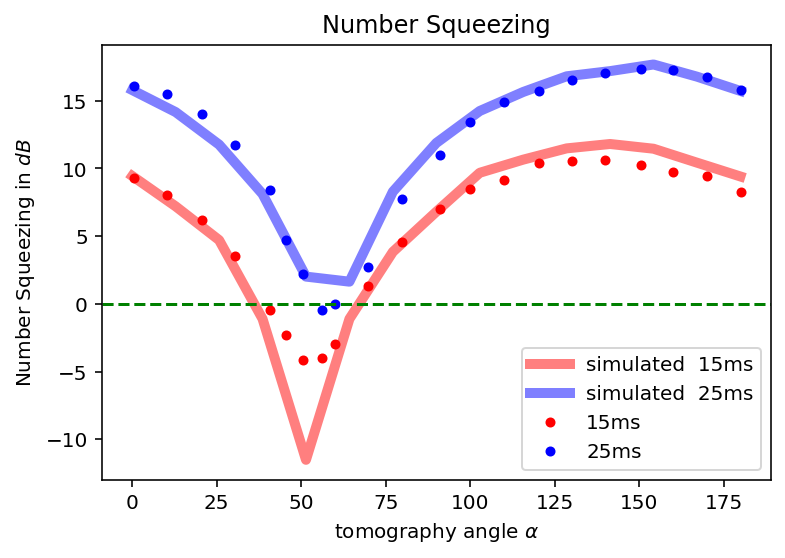

In [28]:
def number_squeezing_factor_to_db(var_CSS, var):
    return 10 * np.log10(var / var_CSS)

f, ax = plt.subplots()
ax.set_title("Number Squeezing")
plt.plot(
    np.rad2deg(alphas),
    number_squeezing_factor_to_db(l / 2, variances_1),
    "r-",
    lw=5,
    label="simulated  15ms",
    alpha=0.5,
)
plt.plot(
    np.rad2deg(alphas),
    number_squeezing_factor_to_db(l / 2, variances_2),
    "b-",
    lw=5,
    label="simulated  25ms",
    alpha=0.5,
)

plt.plot(strobel_15_dB, strobel_15_alpha, 'ro', label="15ms", markersize=4)
plt.plot(strobel_25_dB, strobel_25_alpha, 'bo', label="25ms", markersize=4)


ax.axhline(y=0, color="g", linestyle="--")
ax.set_ylabel(r"Number Squeezing in $dB$")
ax.set_xlabel(r"tomography angle $\alpha$")
ax.legend()